<style>div.container { width: 100% }</style>
<img style="float:left;  vertical-align:text-bottom;" height="65" width="172" src="../assets/holoviz-logo-unstacked.svg" />
<div style="float:right; vertical-align:text-bottom;"><h2>Tutorial 10. Advanced Dashboards</h2></div>

At this point we have learned how to build interactive apps and dashboards with Panel, how to quickly build visualizations with hvPlot, and add custom interactivity by using HoloViews. In this section we will work on putting all of this together to build complex, and efficient data processing pipelines, controlled by Panel widgets.

In [21]:
import colorcet as cc
import dask.dataframe as dd
import holoviews as hv
import numpy as np
import panel as pn
import xarray as xr

import hvplot.pandas # noqa: API import
import hvplot.xarray # noqa: API import

pn.extension()

Before we get started let's once again load the earthquake and population data and define the basic plots, which we will build the dashboard around.

In [22]:
df = dd.read_parquet('../data/earthquakes.parq').repartition(npartitions=4).persist()
most_severe = df[df.mag >= 7].compute()

ds = xr.open_dataarray('../data/gpw_v4_population_density_rev11_2010_2pt5_min.nc')
cleaned_ds = ds.where(ds.values != ds.nodatavals).sel(band=1)
cleaned_ds.name = 'population'

mag_cmap = cc.CET_L4[::-1]

high_mag_points = most_severe.hvplot.points(
    x='longitude', y='latitude', c='mag', hover_cols=['place', 'time'],
    cmap=mag_cmap, tools=['tap'], selection_line_color='black')

rasterized_pop = cleaned_ds.hvplot.image(
    rasterize=True, cmap='kbc', logz=True, clim=(1, np.nan),
    height=500, width=833, xaxis=None, yaxis=None).opts(bgcolor='black')

## Building Pipelines

In the previous sections we built a little function to cache the closest earthquakes since the computation can take a little while. An alternative to this approach is to start building a pipeline in HoloViews to do this very thing. Instead of writing a function that operates directly on the data, we rewrite the function to accept a Dataset and the index. This function again filters the closest earthquakes within the region and returns a new Dataset:

In [23]:
from holoviews.streams import Selection1D

def earthquakes_around_point(ds, index, degrees_dist=0.5):
    if not index:
        return ds.iloc[[]]
    row = high_mag_points.data.iloc[index[0]]
    half_dist = degrees_dist / 2.0
    df = ds.data
    nearest = df[((df['latitude'] - row.latitude).abs() < half_dist) 
                 & ((df['longitude'] - row.longitude).abs() < half_dist)].compute()
    return hv.Dataset(nearest)

Now we declare a HoloViews ``Dataset``, an ``Selection1D`` stream and use the ``apply`` method to apply the function to the dataset. The most important part is that we can now provide the selection stream's index parameter to this apply method. This sets up a pipeline which filters the Dataset based on the current index:

In [24]:
dataset = hv.Dataset(df)
index_stream = Selection1D(source=high_mag_points, index=[-3])

filtered_ds = dataset.apply(earthquakes_around_point, index=index_stream.param.index)

The filtered Dataset object itself doesn't actually display anything but it provides an intermediate pipeline stage which will feed the actual visualizations. The next step therefore is to extend this pipeline to build the visualizations from this filtered dataset. For this purpose we define some functions which take the dataset as input and then generate a plot:

In [25]:
hv.opts.defaults(
    hv.opts.Histogram(toolbar=None),
    hv.opts.Scatter(toolbar=None)
)

def histogram(ds):
    return ds.data.hvplot.hist(y='mag', bin_range=(0, 10), bins=20, color='red', width=400, height=250)

def scatter(ds):
    return ds.data.hvplot.scatter('time', 'mag', color='green', width=400, height=250, padding=0.1)


# We also redefine the VLine
def vline_callback(index):
    if not index:
        return hv.VLine(0)
    row = most_severe.iloc[index[0]]
    return hv.VLine(row.time).opts(line_width=1, color='black')

temporal_vline = hv.DynamicMap(vline_callback, streams=[index_stream])

dynamic_scatter = filtered_ds.apply(scatter)
dynamic_histogram = filtered_ds.apply(histogram)

Now that we have defined our visualizations using lazily evaluated pipelines we can start visualizing it. This time we will use Panel to lay out the plots:

In [26]:
pn.Column(
    rasterized_pop * high_mag_points,
    pn.Row(
        dynamic_scatter * temporal_vline,
        dynamic_histogram
    )
)

Column
    [0] HoloViews(DynamicMap)
    [1] Row
        [0] HoloViews(DynamicMap)
        [1] HoloViews(DynamicMap)

#### Exercise

Define another function like the ``histogram`` or ``scatter`` function and then ``apply`` it to the ``filtered_ds``. Observe how this too will respond to changes in the selected earthquake.

<details><summary>Solution</summary><br>

```python
def bivariate(ds):
    return ds.data.hvplot.bivariate('mag', 'depth')
    
filtered_ds.apply(bivariate)
```
    
</details>

## Connecting widgets to the pipeline

At this point you may be thinking that we haven't done anything we haven't already seen in the previous sections. However, apart from automatically handling the caching of computations, building visualization pipelines in this way provides one major benefit - we can inject parameters at any stage of the pipeline. These parameters can come from anywhere including from Panel widgets, allowing us to expose control over any aspect of our pipeline. 

You may have noticed that the ``earthquakes_around_point`` function takes two arguments, the ``index`` of the point **and** the ``degrees_dist``, which defines the size of the region around the selected earthquake we will select points in. Using ``.apply`` we can declare a ``FloatSlider`` widget and then inject its ``value`` parameter into the pipeline (ensure that an earthquake is selected in the map above):

In [27]:
dist_slider = pn.widgets.FloatSlider(name='Degree Distance', value=0.5, start=0.1, end=2)

filtered_ds = dataset.apply(earthquakes_around_point, index=index_stream.param.index,
                            degrees_dist=dist_slider)

pn.Column(
    dist_slider,
    pn.Row(
        filtered_ds.apply(histogram),
        filtered_ds.apply(scatter)
    )
)

Column
    [0] FloatSlider(end=2, name='Degree Distance', start=0.1, value=0.5)
    [1] Row
        [0] HoloViews(DynamicMap)
        [1] HoloViews(DynamicMap)

When the widget value changes the pipeline will re-execute the part of the pipeline downstream from the function and update the plot. This ensures that only the parts of the pipeline that are actually needed are re-executed.

The ``.apply`` method can also be used to apply options depending on some widget value, e.g. we can create a colormap selector and then use ``.apply.opts`` to connect it to the ``rasterized_pop`` plot:

In [28]:
cmaps  = {n: cc.palette[n] for n in ['kbc', 'fire', 'bgy', 'bgyw', 'bmy', 'gray', 'kbc']}

cmap_selector = pn.widgets.Select(name='Colormap', options=cmaps)

rasterized_pop_cmapped = rasterized_pop.apply.opts(cmap=cmap_selector)

pn.Column(cmap_selector, rasterized_pop_cmapped)

Column
    [0] Select(name='Colormap', options={'kbc': ['#00004e', ...}, value=['#00004e', '#000150', ...])
    [1] HoloViews(DynamicMap)

#### Exercise

Use the ``.apply.opts`` method to control the style of some existing component, e.g. the ``size`` of the points in the ``dynamic_scatter`` plot or the ``color`` of the ``dynamic_histogram``.

<details><summary>Hint</summary><br>

Use a ``ColorPicker`` widget to control the ``color`` or a ``FloatSlider`` widget to control the ``size``. 
    
</details>

<details><summary>Solution</summary><br>

```python
color_picker = pn.widgets.ColorPicker(name='Color', value='#00f300')
size_slider = pn.widgets.FloatSlider(name='Size', value=5, start=1, end=30)
    
color_histogram = dynamic_histogram.apply.opts(color=color_picker.param.value)
size_scatter = dynamic_scatter.apply.opts(size=size_slider.param.value)
    
pn.Column(
    pn.Row(color_picker, size_slider),
    pn.Row(color_histogram, size_scatter)
)
```
    
</details>

## Connecting panels to streams

At this point we have learned how to connect parameters on Panel objects to a pipeline and we earlier learned how we can use parameters to declare dynamic Panel components.  So, this section should be nothing new;, we will simply try to connect the index parameter of the selection stream to a panel to try to compute the number of people in the region around an earthquake.

Since we have a population density dataset we can approximate how many people are affected by a particular earthquake. Of course, this value is only a rough approximation, as it ignores the curvature of the earth, assumes isotropic spreading of the earthquake, and assumes that the population did not change between the measurement and the earthquake. 

In [19]:
@pn.depends(index_stream.param.index, dist_slider)
def affected_population(index, distance):
    if not index:
        return "No earthquake was selected."
    sel = most_severe.iloc[index[0]]
    lon, lat = sel.longitude, sel.latitude
    lon_dist = (np.cos(np.deg2rad(lat)) * 111.321543) * distance
    lat_dist = 111.321543 * distance
    hdist = distance / 2.
    mean_density = cleaned_ds.sel(x=slice(lon-hdist, lon+hdist), y=slice(lat+hdist, lat-hdist)).mean().item()
    population = (lat_dist * lon_dist) * mean_density
    return 'Approximate population around {place}, where a magnitude {mag} earthquake hit on {date} is {pop:.0f}.'.format(
        pop=population, mag=sel.mag, place=sel.place, date=sel.time)

def bounds(index, value):
    if not index:
        return hv.Bounds((0, 0, 0, 0))
    sel = most_severe.iloc[index[0]]
    hdist = value / 2.
    lon, lat = sel.longitude, sel.latitude 
    return hv.Bounds((lon-hdist, lat-hdist, lon+hdist, lat+hdist))  

dynamic_bounds = hv.DynamicMap(bounds, streams=[index_stream, dist_slider.param.value])

pn.Column(pn.panel(affected_population, width=400), rasterized_pop * high_mag_points * dynamic_bounds, dist_slider)

Column
    [0] ParamFunction(function, width=400)
    [1] HoloViews(DynamicMap)
    [2] FloatSlider(end=2, name='Degree Distance', start=0.1, value=0.5)

## The full dashboard

Finally let us put all these components together into an overall dashboard, which we will mark as ``servable`` so we can ``panel serve`` this notebook.

Column
    [0] Row
        [0] Column
            [0] Markdown(str)
            [1] ParamFunction(function, width=400)
        [1] Spacer(width=10)
        [2] PNG(str, align='center', width=200)
        [3] HSpacer()
        [4] WidgetBox
            [0] FloatSlider(end=2, name='Degree Distance', start=0.1, value=0.5)
            [1] Select(name='Colormap', options={'kbc': ['#00004e', ...}, value=['#00004e', '#000150', ...])
    [1] Row
        [0] HoloViews(DynamicMap)
        [1] Column
            [0] HoloViews(DynamicMap)
            [1] HoloViews(DynamicMap)
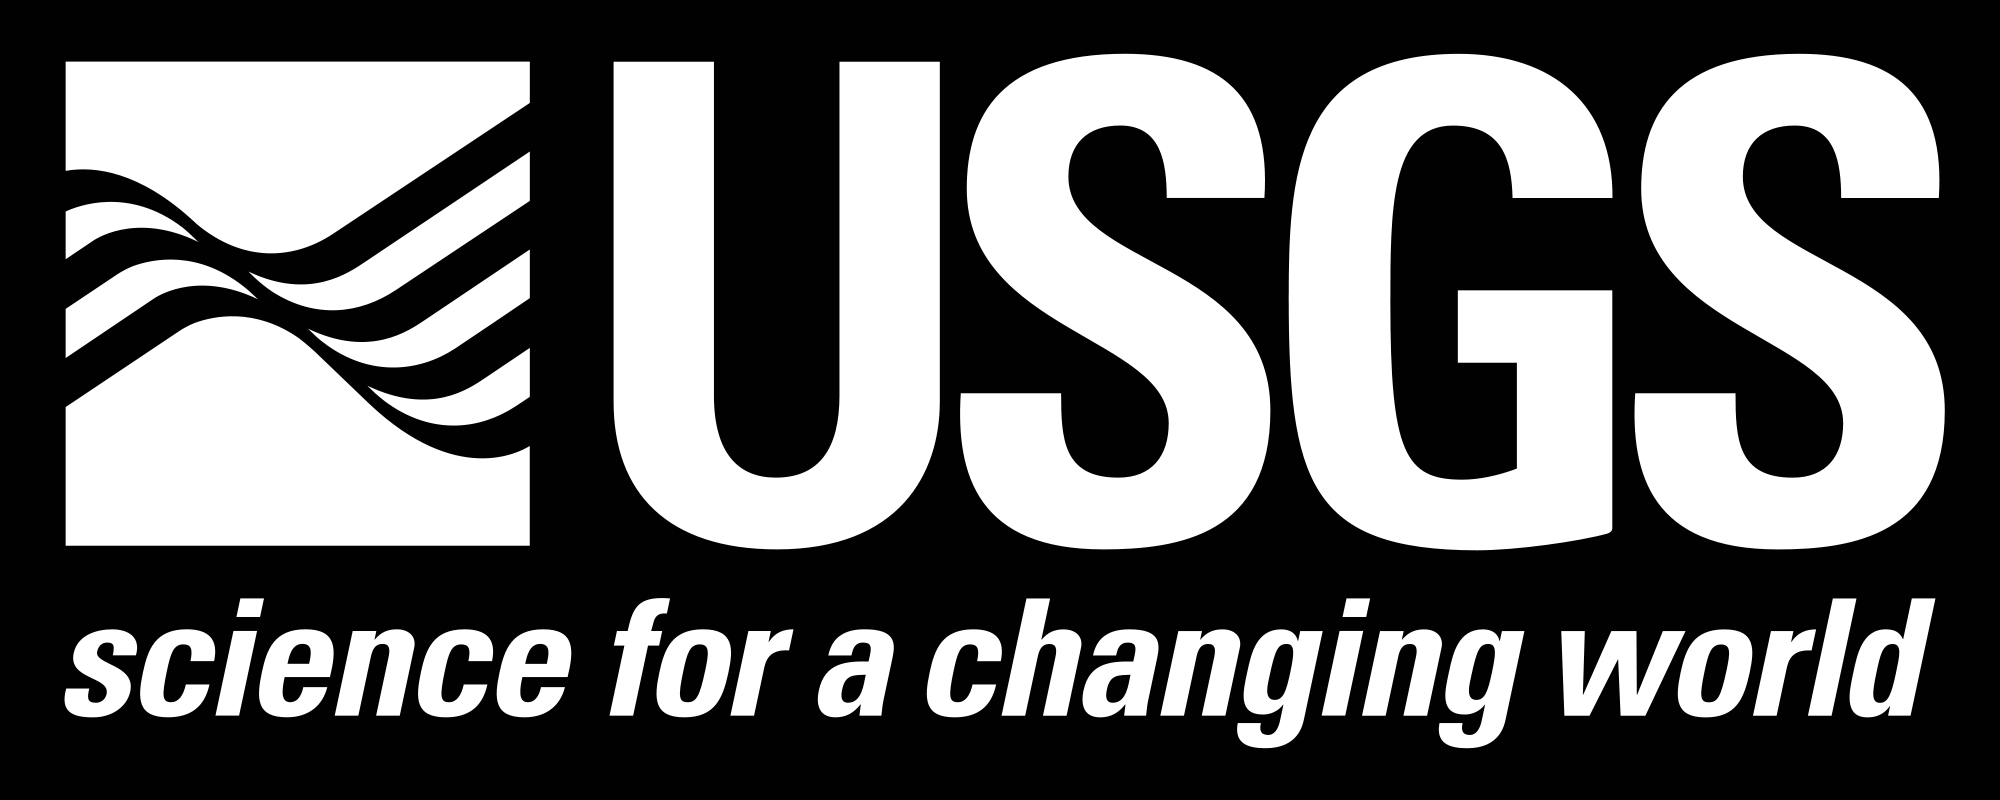

In [20]:
title = '## Major Earthquakes 2000-2018'
logo = pn.panel('../assets/usgs_logo.png', width=200, align='center')
widgets = pn.WidgetBox(dist_slider, cmap_selector, margin=5)

header = pn.Row(pn.Column(title, pn.panel(affected_population, width=400)),
                pn.layout.Spacer(width=10), logo, pn.layout.HSpacer(), widgets)

dynamic_scatter = filtered_ds.apply(scatter)
dynamic_histogram = filtered_ds.apply(histogram)
temporal_vline = hv.DynamicMap(vline_callback, streams=[index_stream])
rasterized_pop_cmapped = rasterized_pop.apply.opts(cmap=cmap_selector.param.value)
dynamic_bounds = hv.DynamicMap(bounds, streams=[index_stream, dist_slider.param.value])

body = pn.Row(
    rasterized_pop_cmapped * high_mag_points * dynamic_bounds,
    pn.Column(dynamic_scatter * temporal_vline, dynamic_histogram),
)

pn.Column(header, body).servable()